In [ ]:
# Step 0: Setup & Imports
# =========================
import os, math, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
# Reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [ ]:
# ================
# Step 1: Load Data
# ================
df = pd.read_csv("/AAPL.csv", parse_dates=['Date'])
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,1980-12-12,0.513393
1,1980-12-15,0.486607
2,1980-12-16,0.450893
3,1980-12-17,0.462054
4,1980-12-18,0.475446


In [ ]:
# প্রয়োজনীয় কলাম রেখে দিই
df = df[['Date', 'Close']].copy()

# Clean & Sort
df = df.drop_duplicates(subset=['Date']).sort_values('Date').reset_index(drop=True)
df = df.dropna(subset=['Close'])

print("Rows:", len(df), "| Date Range:", df['Date'].min().date(), "->", df['Date'].max().date())
df.head()

Rows: 9822 | Date Range: 1980-12-12 -> 2019-11-25


,Date,Close
0,1980-12-12,0.513393
1,1980-12-15,0.486607
2,1980-12-16,0.450893
3,1980-12-17,0.462054
4,1980-12-18,0.475446


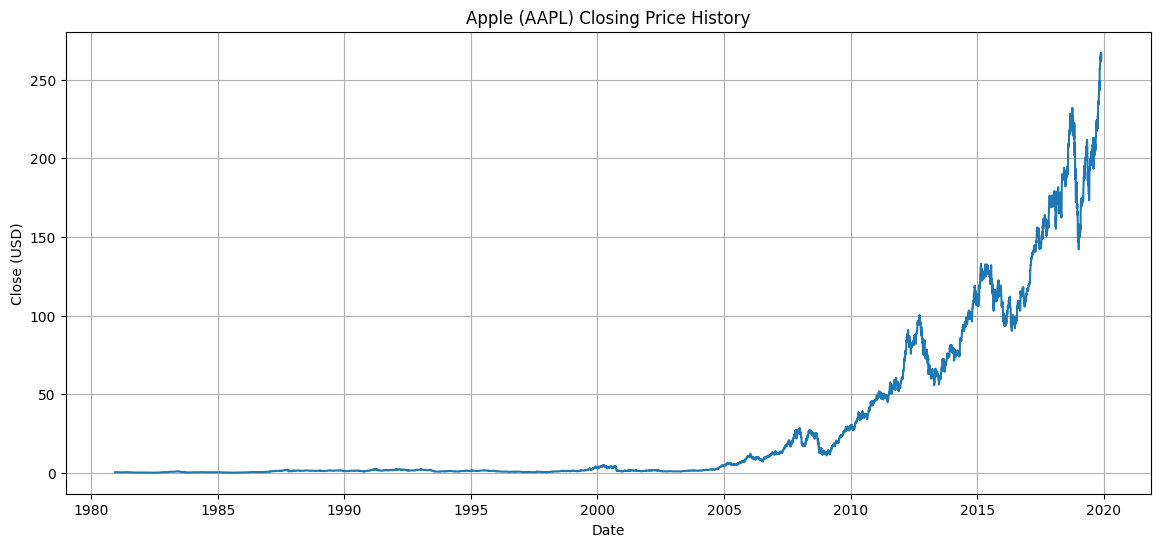

In [ ]:
# ===========================
# Step 2: Quick EDA (Optional)
# ===========================
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'])
plt.title("Apple (AAPL) Closing Price History")
plt.xlabel("Date")
plt.ylabel("Close (USD)")
plt.grid(True)
plt.show()

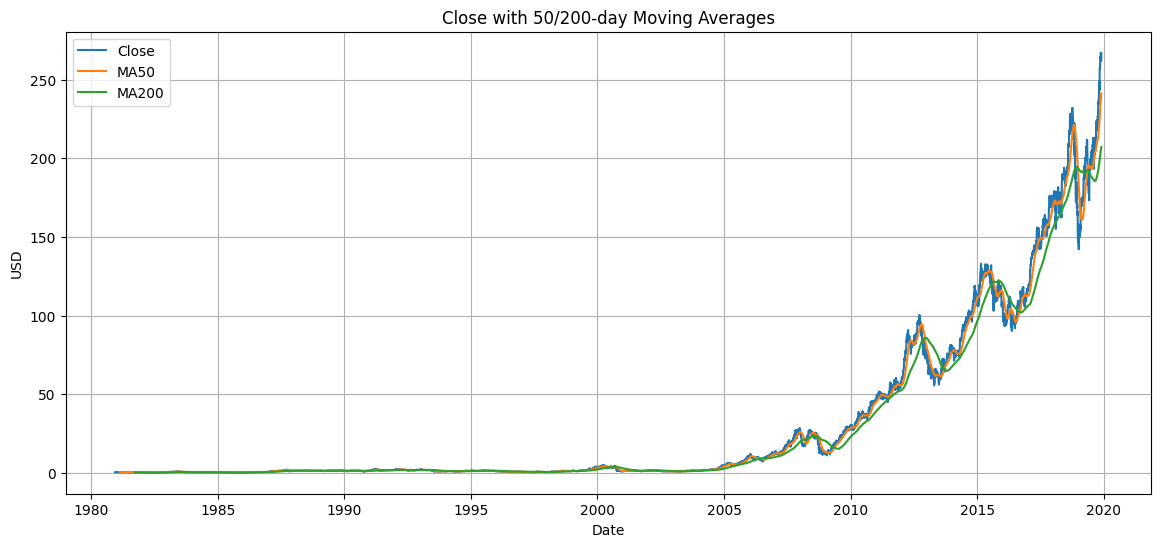

In [ ]:
# Moving Averages (optional)
df['MA50'] = df['Close'].rolling(window=50).mean()
df['MA200'] = df['Close'].rolling(window=200).mean()

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label="Close")
plt.plot(df['Date'], df['MA50'], label="MA50")
plt.plot(df['Date'], df['MA200'], label="MA200")
plt.title("Close with 50/200-day Moving Averages")
plt.xlabel("Date"); plt.ylabel("USD"); plt.legend(); plt.grid(True)
plt.show()

In [ ]:
# =================================
# Step 3: Feature & Scaling (Close)
# =================================
values = df[['Close']].values  # shape: (N, 1)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

TIME_STEPS = 60  # গত 60 দিনের উইন্ডো দিয়ে পরের দিনের প্রাইস প্রেডিক্ট
N = len(scaled)
# ====================
# Step 4: Data Scaling
# ====================
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df['Close'].values.reshape(-1,1))

print("Scaled data shape:", scaled_data.shape)


Scaled data shape: (9822, 1)


In [ ]:
# =============================
# Step 3: Scaling (Normalization)
# =============================
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df[['Close']].values)

print("Scaled data shape:", data_scaled.shape)

# =============================
# Step 4: Train/Val/Test Splits
# =============================
N = len(data_scaled)

# Split index বের করা
train_ratio, val_ratio = 0.70, 0.15
train_end   = int(N * train_ratio)
val_end     = train_end + int(N * val_ratio)   # বাকি অংশ test set

# Data ভাগ করা
train_data = data_scaled[:train_end]
val_data   = data_scaled[train_end:val_end]
test_data  = data_scaled[val_end:]

print("Train shape:", train_data.shape)
print("Val shape:", val_data.shape)
print("Test shape:", test_data.shape)


Scaled data shape: (9822, 1)
Train shape: (6875, 1)
Val shape: (1473, 1)
Test shape: (1474, 1)


In [ ]:
# =========================
# Step 5: Build LSTM Model
# =========================
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(TIME_STEPS, 1)),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 60, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,857 (116.63 KB)

 Trainable params: 29,857 (116.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ============================
# Step 6: Train with Callbacks
# ============================
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint('best_lstm_aapl.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 16s 57ms/step - loss: 6.5869e-05 - val_loss: 1.1351e-04 - learning_rate: 0.0010
Epoch 2/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 7.6903e-06 - val_loss: 9.0754e-05 - learning_rate: 0.0010
Epoch 3/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 12s 56ms/step - loss: 8.8883e-06 - val_loss: 4.3950e-04 - learning_rate: 0.0010
Epoch 4/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 11s 49ms/step - loss: 6.6463e-06 - val_loss: 1.3830e-04 - learning_rate: 0.0010
Epoch 5/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - loss: 5.2986e-06 - val_loss: 5.2375e-04 - learning_rate: 5.0000e-04
Epoch 6/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - loss: 3.8849e-06 - val_loss: 1.9314e-04 - learning_rate: 5.0000e-04
Epoch 7/30
213/213 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - loss: 4.4197e-06 - val_loss: 1.1019e-04 - learning_rate: 5.0000e-04


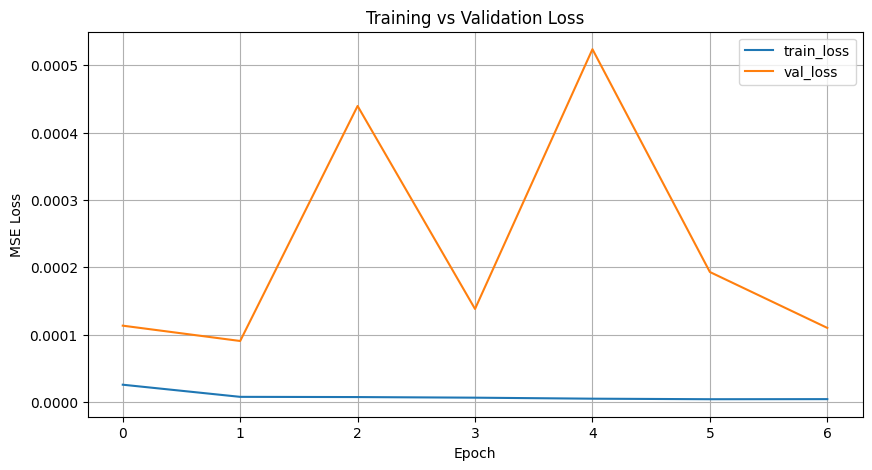

In [ ]:
 #Training curves
plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(); plt.grid(True)
plt.show()

In [ ]:
# Step 7: Prediction
# ===================
# Validation & Test predictions
pred_val_scaled  = model.predict(X_val)
pred_test_scaled = model.predict(X_test)

# Inverse transform back to original price scale
pred_val  = scaler.inverse_transform(pred_val_scaled)
pred_test = scaler.inverse_transform(pred_test_scaled)

y_val_inv  = scaler.inverse_transform(y_val.reshape(-1,1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1,1))


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [ ]:
# ==================
# Step 8: Evaluation
# ==================
def metrics(y_true, y_pred):
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

rmse_v, mae_v, mape_v = metrics(y_val_inv,  pred_val)
rmse_t, mae_t, mape_t = metrics(y_test_inv, pred_test)

print("Validation -> RMSE: {:.4f}, MAE: {:.4f}, MAPE: {:.2f}%".format(rmse_v, mae_v, mape_v))
print("Test       -> RMSE: {:.4f}, MAE: {:.4f}, MAPE: {:.2f}%".format(rmse_t, mae_t, mape_t))


Validation -> RMSE: 2.5427, MAE: 1.8876, MAPE: 4.59%
Test       -> RMSE: 15.1377, MAE: 10.3124, MAPE: 6.02%


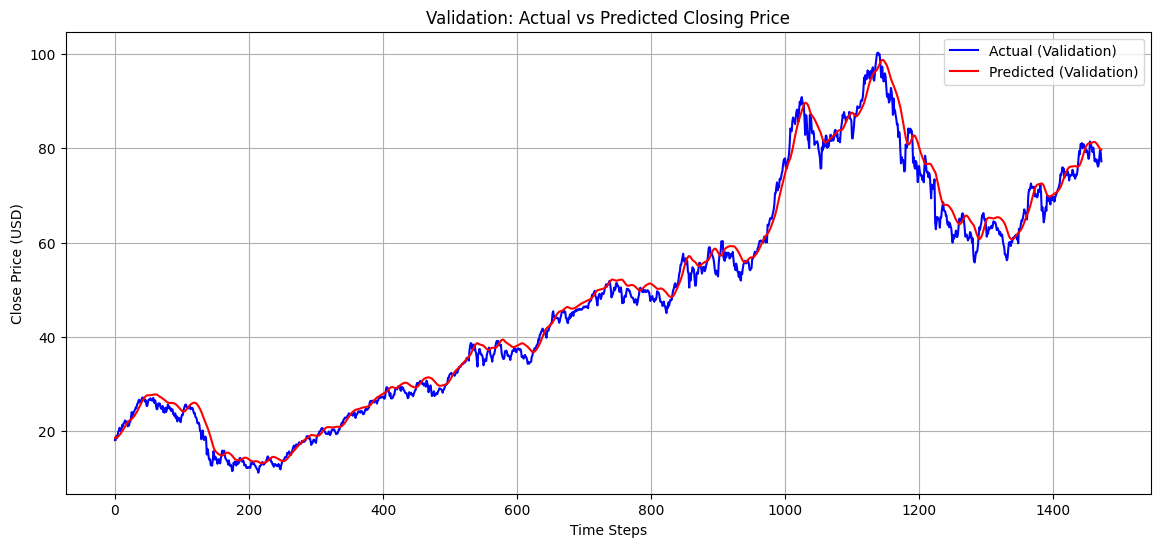

In [ ]:
# Validation plot
plt.figure(figsize=(14,6))
plt.plot(y_val_inv, label='Actual (Validation)', color='blue')
plt.plot(pred_val, label='Predicted (Validation)', color='red')
plt.title("Validation: Actual vs Predicted Closing Price")
plt.xlabel("Time Steps")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()


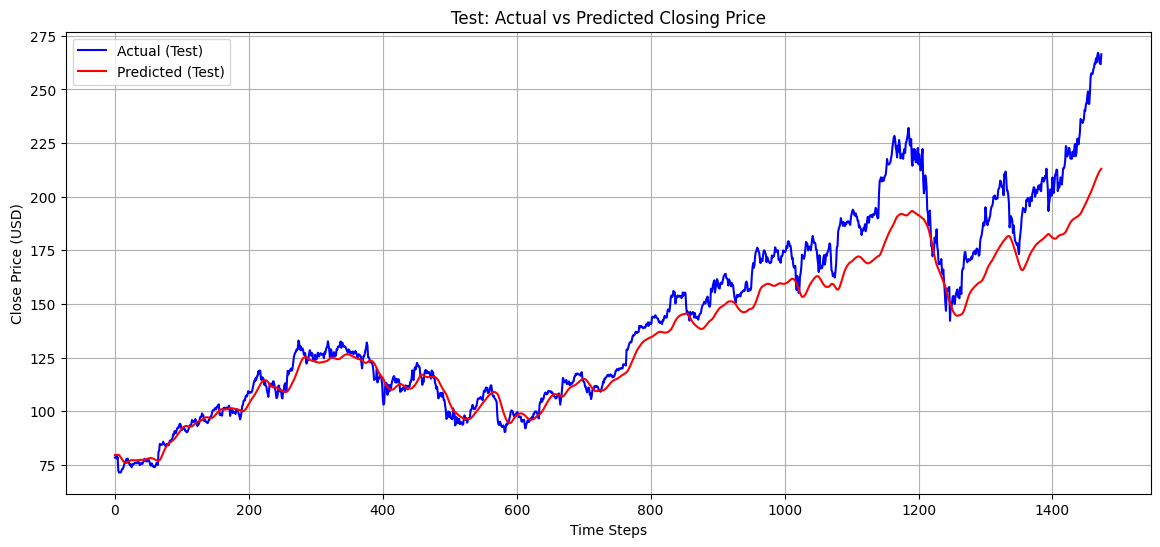

In [ ]:
# Test plot
plt.figure(figsize=(14,6))
plt.plot(y_test_inv, label='Actual (Test)', color='blue')
plt.plot(pred_test, label='Predicted (Test)', color='red')
plt.title("Test: Actual vs Predicted Closing Price")
plt.xlabel("Time Steps")
plt.ylabel("Close Price (USD)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# =============================
# Step 10: Future Forecasting
# =============================
future_days = 30   # কত দিনের prediction করবে
time_step = X_train.shape[1]   # training এর সময় sequence length

# শেষ sequence (training data থেকে)
last_seq = data_scaled[-time_step:]
future_preds = []

cur_seq = last_seq.reshape(1, time_step, 1)

for _ in range(future_days):
    pred = model.predict(cur_seq, verbose=0)[0][0]
    future_preds.append(pred)

    # নতুন prediction sequence এ যোগ করা
    cur_seq = np.append(cur_seq[:, 1:, :], [[[pred]]], axis=1)

# scale inverse করে আসল প্রাইস বের করা
future_preds = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Future তারিখ বানানো
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(last_date, periods=future_days+1, freq='B')[1:]

# DataFrame বানানো
future_df = pd.DataFrame({'Date': future_dates, 'Predicted_Close': future_preds.flatten()})

print(future_df.head())


        Date  Predicted_Close
0 2019-11-26       213.327957
1 2019-11-27       212.737518
2 2019-11-28       211.520309
3 2019-11-29       209.873322
4 2019-12-02       207.911621


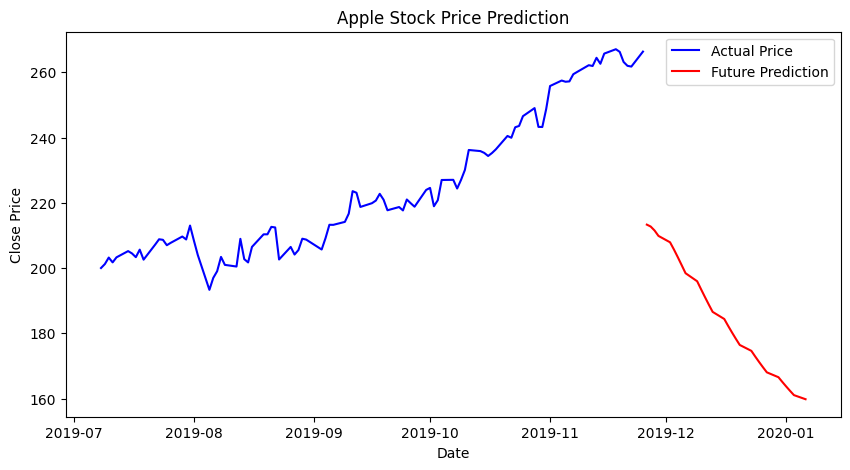

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df['Date'][-100:], df['Close'][-100:], label="Actual Price", color="blue")   # শেষ 100 দিনের আসল দাম
plt.plot(future_df['Date'], future_df['Predicted_Close'], label="Future Prediction", color="red")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Apple Stock Price Prediction")
plt.legend()
plt.show()
